In [34]:
# Importa las bibliotecas necesarias
import numpy as np  # Biblioteca para trabajar con arrays y operaciones numéricas
import pandas as pd  # Biblioteca para la manipulación y análisis de datos
import matplotlib.pyplot as plt  # Biblioteca para la creación de gráficos
from sklearn.cluster import KMeans  # Importa el algoritmo de clustering K-Means de scikit-learn
from sklearn.decomposition import PCA  # Importa la clase para Análisis de Componentes Principales (PCA) de scikit-learn

In [35]:
# Define la URL que apunta a un archivo CSV almacenado en Google Sheets
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSLo2NoEd47ZPZnEeDQBO95NHxvMsUi7YG4nH9DEiDfMJIV2q5Qk0fPQX5J10ClRB7ixPrCbfkTHcTh/pub?output=csv"

# Lee los datos desde el archivo CSV en la URL utilizando pandas y los almacena en un DataFrame
data = pd.read_csv(url)

In [36]:
# Definir las columnas de interés que queremos conservar en el DataFrame
columnas_objetivo = [
    'Name', 'OVR', 'PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY',  # Estadísticas generales de los jugadores
    'Acceleration', 'Sprint Speed', 'Positioning', 'Finishing',  # Habilidades físicas y de ataque
    'Shot Power', 'Long Shots', 'Volleys', 'Penalties',  # Estadísticas relacionadas con el disparo
    'Vision', 'Crossing', 'Free Kick Accuracy', 'Short Passing',  # Habilidades de pase y visión
    'Long Passing', 'Curve', 'Dribbling', 'Agility',  # Más habilidades de pase y control del balón
    'Balance', 'Reactions', 'Ball Control', 'Composure',  # Habilidades de control y reacciones
    'Interceptions', 'Heading Accuracy', 'Def Awareness',  # Habilidades defensivas
    'Standing Tackle', 'Sliding Tackle', 'Jumping',  # Estadísticas de defensa y salto
    'Stamina', 'Strength', 'Aggression', 'Weak foot',  # Habilidades físicas y de pie débil
    'Skill moves', 'Age', 'GK Diving', 'GK Handling',  # Habilidades generales y de portero
    'GK Kicking', 'GK Positioning', 'GK Reflexes',  # Más habilidades de portero
    'Preferred foot', 'Nation', 'Position'  # Información del jugador (nacionalidad, pie preferido, posición)
]

# Obtiene todas las columnas presentes en el DataFrame 'data'
columnas = data.columns

# Iterar sobre todas las columnas del DataFrame 'data'
for col in columnas:
    if col not in columnas_objetivo:  # Si la columna actual no está en la lista de interés
        data.drop(col, axis=1, inplace=True)  # Elimina la columna del DataFrame
    else:
        data[col] = data[col]  # Si la columna está en la lista, la mantiene (esto no cambia nada, pero es redundante)

In [37]:
# Definir las columnas que corresponden a las estadísticas de los porteros (GK)
gk_columns = ['GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes']

# Imputar los datos faltantes (NaN) en estas columnas, reemplazándolos con 0
# Esto se hace porque los jugadores que no son porteros usualmente tienen estas columnas vacías
data[gk_columns] = data[gk_columns].fillna(0)

In [38]:
# Extraer los datos de características (variables independientes) del DataFrame
# Se toma desde la segunda columna (índice 1) hasta la penúltima columna (excluyendo la primera y la última)
# La primera columna ('Name') es usualmente un identificador, y la última ('Position' o similar) es la variable objetivo
X = data.iloc[:, 1:-1].values  # '.iloc' permite seleccionar filas y columnas por su posición en el índice

In [39]:
# Importa la clase LabelEncoder para convertir variables categóricas en valores numéricos
from sklearn.preprocessing import LabelEncoder

# Crear una instancia del codificador de etiquetas
le = LabelEncoder()

# Codificar la penúltima columna, que corresponde al 'Preferred foot' (pie preferido)
# El método 'fit_transform' ajusta el codificador a los datos y luego los transforma, convirtiendo las categorías en números
X[:, -2] = le.fit_transform(X[:, -2])

# Codificar la última columna, que corresponde a 'Nation' (nacionalidad)
# Nuevamente, se ajusta el codificador a esta columna y se transforman los valores categóricos en numéricos
X[:, -1] = le.fit_transform(X[:, -1])

In [40]:
# Crear un DataFrame a partir de los datos numéricos almacenados en X
df = pd.DataFrame(X)

# Iterar sobre todas las columnas del DataFrame
for col in df.columns:
    # Convertir los valores de cada columna a tipo numérico
    # El parámetro 'errors="coerce"' asegura que cualquier valor que no pueda convertirse a numérico se convertirá a NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [41]:
# Convertir el DataFrame 'df' en un array de valores de tipo NumPy
# Esto es útil cuando se necesita trabajar directamente con matrices NumPy en lugar de DataFrames de pandas
X = df.values

In [42]:
# Importa la clase SimpleImputer de scikit-learn para manejar valores faltantes
from sklearn.impute import SimpleImputer

# Crea una instancia de SimpleImputer especificando que se deben imputar los valores faltantes (NaN) con la mediana de cada columna
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Ajusta el imputador a los datos X, es decir, calcula la mediana de cada columna en X
imputer.fit(X)

# Transforma X reemplazando los valores faltantes por la mediana calculada
X = imputer.transform(X)

In [43]:
# Extraer todos los datos de X, excepto la última columna que corresponde a la nacionalidad
X_ = X[:, :-1]  # Esto selecciona todas las filas y todas las columnas excepto la última

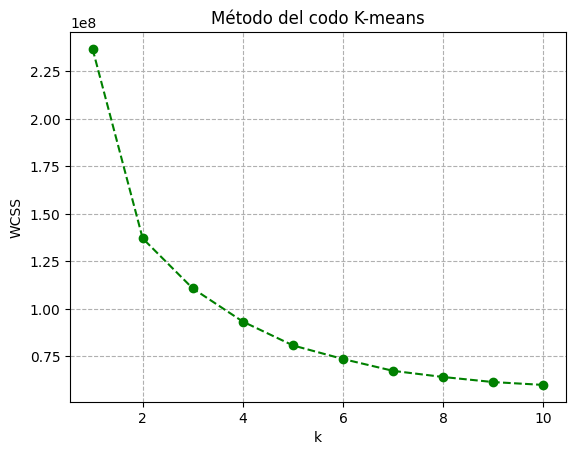

In [44]:
# Importa la clase KMeans del módulo de clustering de scikit-learn
from sklearn.cluster import KMeans

# Inicializa una lista donde se almacenará el WCSS (Within-Cluster Sum of Squares)
WCSS = []  # Lista para almacenar los valores de WCSS para diferentes números de clústeres k

# Calcular WCSS para valores de k de 1 a 10
for k in range(1, 11):
    # Inicializa el modelo KMeans con el número de clústeres k
    kpp = KMeans(n_clusters=k,  # Especifica el número de clústeres
                 random_state=42,  # Establece una semilla para la aleatoriedad (para reproducibilidad)
                 n_init='auto')  # Usa el valor predeterminado para el número de inicializaciones (n_init)

    # Ajusta el modelo KMeans a los datos X
    kpp.fit(X)

    # Almacena el WCSS (inercia) para este valor de k en la lista
    WCSS.append(kpp.inertia_)

# Graficar el resultado
plt.figure()  # Crea una nueva figura para el gráfico
# Grafica los valores de WCSS en función de k, usando círculos y líneas discontinuas
plt.plot(range(1, 11), WCSS, 'o--', color='green')
plt.title('Método del codo K-means')  # Título del gráfico
plt.xlabel('k')  # Etiqueta del eje X (número de clústeres)
plt.ylabel('WCSS')  # Etiqueta del eje Y (Within-Cluster Sum of Squares)
plt.grid(True)  # Activa la cuadrícula en el gráfico
plt.grid(linestyle='--')  # Define el estilo de las líneas de la cuadrícula como discontinuas
plt.show()  # Muestra el gráfico

In [45]:
# Importa la clase KMeans del módulo de clustering de scikit-learn
from sklearn.cluster import KMeans

# Inicializa el modelo KMeans con 4 clústeres y una semilla aleatoria para la reproducibilidad
kmeans = KMeans(n_clusters=4, random_state=42)  # 'n_clusters' define el número de clústeres a crear

# Ajusta el modelo a los datos X_ y almacena las etiquetas de clúster asignadas a cada muestra
clusters_kmeans = kmeans.fit_predict(X_)  # 'fit_predict' ajusta el modelo y devuelve las etiquetas de clúster

In [46]:
# Obtener los centroides de los clústeres generados por el modelo KMeans
centroides_kmeans = kmeans.cluster_centers_  # 'cluster_centers_' contiene las coordenadas de los centroides de los clústeres

In [47]:
# Importa la clase PCA del módulo de descomposición de scikit-learn
from sklearn.decomposition import PCA

# Re-definir X_ excluyendo la última columna si no se había hecho antes
X_ = X[:, :-1]

# Crear un objeto PCA que busca reducir la dimensionalidad a 3 componentes principales
pca = PCA(n_components=3)  # n_components especifica el número de componentes que se desean

# Ajustar el modelo PCA a los datos y transformar los datos a las nuevas componentes
X_pca = pca.fit_transform(X_)  # 'fit_transform' ajusta el modelo y transforma los datos a las componentes principales

In [48]:
# Ajustar el modelo PCA a los datos en X_ y transformar los datos a las nuevas componentes principales
X_pca = pca.fit_transform(X_)  # 'fit_transform' calcula las componentes principales y transforma los datos a ese nuevo espacio

In [49]:
# Importa la biblioteca seaborn para la visualización
import seaborn as sns

# Define una función para graficar los clústeres en 2D usando PCA
def graficar_clusters_PCA2D(clusters, metodo, centroids):
    # Crear un gráfico de dispersión 2D usando las dos primeras componentes principales
    plt.figure(figsize=(20, 10))  # Define el tamaño de la figura
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],  # Usa las dos primeras componentes principales para los ejes X e Y
                    hue=clusters,  # Colorea los puntos según los clústeres
                    palette='viridis',  # Paleta de colores
                    alpha=0.6,  # Translucidez de los puntos
                    s=100)  # Tamaño de los puntos en el gráfico

    # Añadir los centroides de los clústeres al gráfico
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, label='centroides')
    plt.title(f'Visualización 2D de la Clusterización (PCA) {metodo}', fontsize=16)  # Título del gráfico
    plt.xlabel('Componente Principal 1')  # Etiqueta del eje X
    plt.ylabel('Componente Principal 2')  # Etiqueta del eje Y
    plt.grid(True)  # Activa la cuadrícula
    plt.grid(linestyle='-', alpha=0.5)  # Define el estilo de la cuadrícula
    plt.legend(title='Cluster')  # Muestra la leyenda con el título "Cluster"
    plt.show()  # Muestra el gráfico


In [50]:
# Importa la clase Axes3D de mpl_toolkits para crear gráficos 3D
from mpl_toolkits.mplot3d import Axes3D

# Define una función para graficar los clústeres en 3D usando PCA
def graficar_clusters_PCA3D(clusters, metodo):
    # Crear el gráfico 3D
    fig = plt.figure(figsize=(20, 10))  # Define el tamaño de la figura
    ax = fig.add_subplot(111, projection='3d')  # Añade un subplot en 3D

    # Graficar los puntos en 3D, coloreando según los clústeres
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],  # Usar las tres componentes principales
                         c=clusters,  # Colorear los puntos según los clústeres
                         cmap='viridis',  # Paleta de colores
                         s=100,  # Tamaño de los puntos
                         edgecolor='white',  # Color del borde de los puntos
                         alpha=0.6)  # Translucidez de los puntos

    # Etiquetas de los ejes y título
    ax.set_title(f'Visualización 3D de la Clusterización (PCA) {metodo}', fontsize=16)  # Título del gráfico
    ax.set_xlabel('Componente Principal 1')  # Etiqueta del eje X
    ax.set_ylabel('Componente Principal 2')  # Etiqueta del eje Y
    ax.set_zlabel('Componente Principal 3')  # Etiqueta del eje Z

    # Añadir la leyenda al gráfico
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")  # Crear la leyenda basada en los colores de los clústeres
    ax.add_artist(legend1)  # Añadir la leyenda al gráfico

    # Mostrar el gráfico
    plt.show()  # Muestra el gráfico

In [51]:
# Transformar los centroides de los clústeres al espacio de las componentes principales usando el modelo PCA
centroides_kmeans_pca = pca.transform(centroides_kmeans)  # 'transform' aplica la reducción de dimensionalidad a los centroides

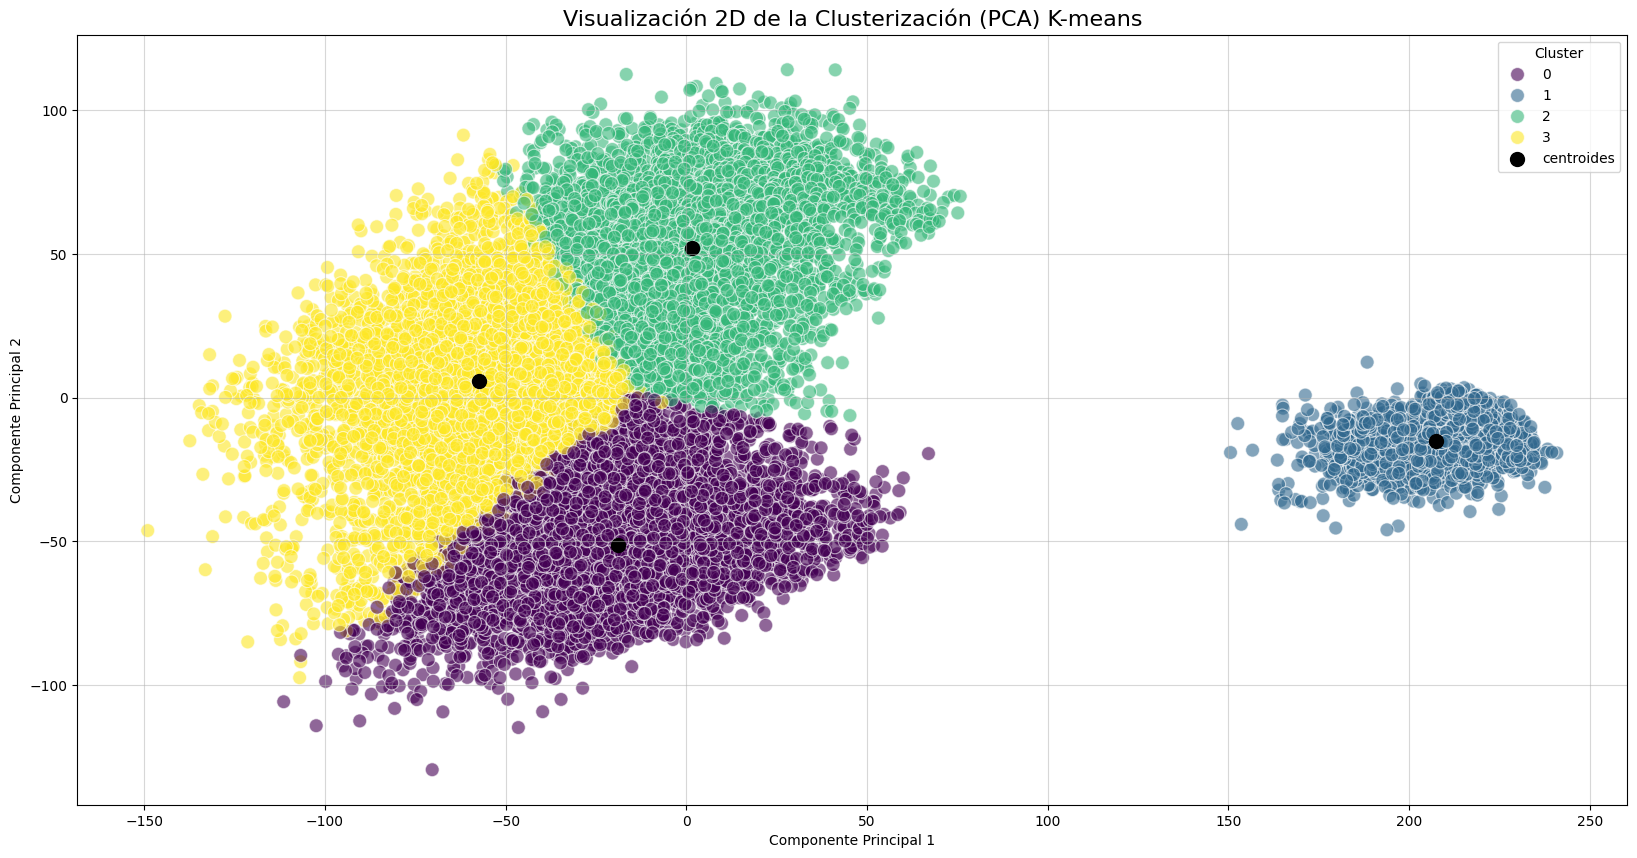

In [52]:
# Llama a la función graficar_clusters_PCA2D para visualizar los clústeres en 2D
kmeans_2D = graficar_clusters_PCA2D(clusters_kmeans, 'K-means', centroides_kmeans_pca)

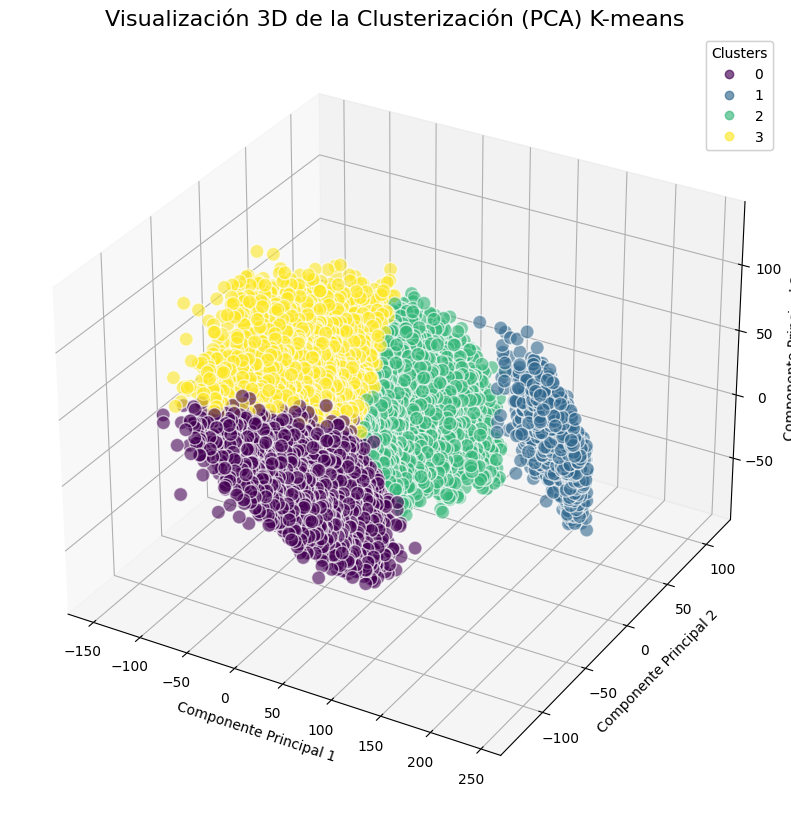

In [53]:
# Llama a la función graficar_clusters_PCA3D para visualizar los clústeres en 3D
kmeans_3D = graficar_clusters_PCA3D(clusters_kmeans, 'K-means')